### Домашнее задание 2

### Выполнил Партин Максим

In [1]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchvision import transforms
from numpy.random import default_rng
from tqdm import tqdm
from sklearn.metrics import f1_score

torch.manual_seed(42)
np.random.seed(42)

### Загрузка датасета cifar10


In [2]:
# Словарь для перевода классов из датасета в текстовое название их
dataset_classes = {
  0: "airplane",
  1: "automobile",
  2: "bird",
  3: "cat",
  4: "deer",
  5: "dog",
  6: "frog",
  7: "horse",
  8: "ship",
  9: "truck",
}

# Преобразования для перевода из PIL изображения в torch tensor
transform = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)


train_dataset = torchvision.datasets.CIFAR10("/data", train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10("/data", train=False, download=True, transform=transform)

100%|██████████| 170M/170M [00:03<00:00, 43.3MB/s]


Напишем функцию для показа случайных изображений из датасета

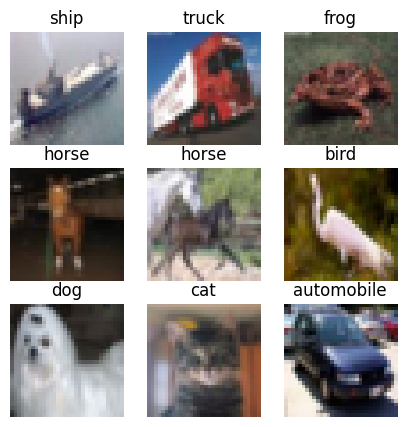

In [3]:
def show_random_images(dataset):
  fix, axes = plt.subplots(3, 3, figsize=(5, 5))
  rng = default_rng()
  random_images_indexes = rng.choice(len(dataset), size=9, replace=False)
  random_images_indexes = random_images_indexes.reshape((3, 3))
  for i in range(3):
    for j in range(3):
      image_index = random_images_indexes[i][j]
      axes[i][j].imshow(dataset[image_index][0].permute(1, 2, 0).numpy())
      class_name = dataset_classes[dataset[image_index][1]]
      axes[i][j].set_title(class_name)
      axes[i][j].axis("off")
  plt.axis("off")
  plt.show()

show_random_images(train_dataset)

Посчитаем среднюю и дисперсию для тренировочной выборки, будем использовать это для того, чтобы подавать на вход моделям нормализованные данные

In [4]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle=False, batch_size=64) # В данном случае не нужно шафлить, так как еще не обучаем сеть

mean = torch.Tensor([0.0, 0.0, 0.0])
std = torch.Tensor([0.0, 0.0, 0.0])
for images, _ in train_dataloader:
  batch_size = images.size(0)
  images = images.view(batch_size, images.size(1), -1)
  mean += images.mean(2).sum(0)
  std += images.std(2).sum(0)

mean = mean / len(train_dataloader.dataset)
std = std / len(train_dataloader.dataset)
print(f"mean: {mean}, std: {std}")

mean: tensor([0.4914, 0.4822, 0.4465]), std: tensor([0.2023, 0.1994, 0.2010])


Загрузим заново изображения в датасет, теперь применив нормализацию исходя из подсчитанных среднего и дисперсии

In [5]:
# Преобразования для перевода из PIL изображения в torch tensor
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.4914, 0.4822, 0.4465],
            std=[0.2023, 0.1994, 0.2010],
        ),
    ]
)


train_dataset = torchvision.datasets.CIFAR10("/data", train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10("/data", train=False, download=True, transform=transform)

### обучение KNN

Для обучения KNN воспользуемся его реализацией из библиотеки [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)

Для начала преобразуем датасет из формата torch в numpy массивы

In [6]:
%%time
def torch_dataset_to_numpy(dataset: torch.utils.data.Dataset) -> tuple[np.ndarray, np.ndarray]:
  np_images = []
  np_labels = []
  for image, label in dataset:
    np_images.append(image.flatten().numpy())
    np_labels.append(label)
  return np.array(np_images), np.array(np_labels)

train_np_images, train_np_labels = torch_dataset_to_numpy(train_dataset)
test_np_images, test_np_labels = torch_dataset_to_numpy(test_dataset)

CPU times: user 15 s, sys: 680 ms, total: 15.7 s
Wall time: 15.8 s


Теперь обучим KNN на train

In [7]:
%%time

from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(train_np_images, train_np_labels)

CPU times: user 265 ms, sys: 13.9 ms, total: 279 ms
Wall time: 379 ms


KNeighborsClassifier()

Посчитаем метрики на test части датасета

In [8]:
%%time
predicted_labels = knn_model.predict(test_np_images)

CPU times: user 1min 13s, sys: 114 ms, total: 1min 13s
Wall time: 1min 14s


In [14]:
from sklearn.metrics import classification_report

print(classification_report(test_np_labels, predicted_labels, target_names=list(dataset_classes.values())))

              precision    recall  f1-score   support

    airplane       0.38      0.54      0.44      1000
  automobile       0.65      0.21      0.31      1000
        bird       0.23      0.45      0.30      1000
         cat       0.29      0.22      0.25      1000
        deer       0.24      0.51      0.33      1000
         dog       0.39      0.22      0.28      1000
        frog       0.34      0.25      0.29      1000
       horse       0.67      0.21      0.32      1000
        ship       0.40      0.66      0.50      1000
       truck       0.70      0.14      0.23      1000

    accuracy                           0.34     10000
   macro avg       0.43      0.34      0.33     10000
weighted avg       0.43      0.34      0.33     10000



**Вывод:** Видим, что модель лучше всего научилась предсказывать класс грузовика. Хуже всего класс птицы

---



Построим несколько предсказаний модели

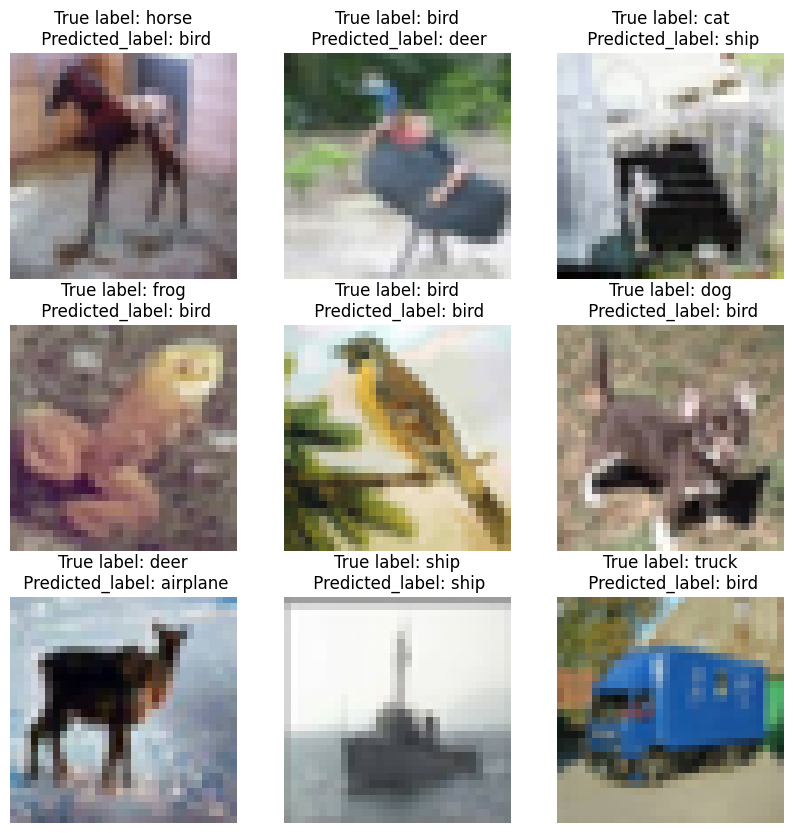

In [62]:
# Преобразования для перевода из PIL изображения в torch tensor.
# Нормализация была удалена для просмотра результата
transform = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)


test_dataset = torchvision.datasets.CIFAR10("/data", train=False, download=True, transform=transform)
test_np_images, test_np_labels = torch_dataset_to_numpy(test_dataset)
random_indices_for_demo = np.random.choice(np.arange(1, test_np_images.shape[0]), size=9, replace=False).reshape(3, 3)

fix, axes = plt.subplots(3, 3, figsize=(10, 10))

for i in range(3):
  for j in range(3):
    image_idx = random_indices_for_demo[i, j]
    image = test_np_images[image_idx].reshape(3, 32, 32).transpose(1, 2, 0)
    axes[i][j].imshow(image)
    true_label = dataset_classes[test_np_labels[image_idx]]
    predicted_label = dataset_classes[predicted_labels[image_idx]]
    title = f"True label: {true_label}\n Predicted_label: {predicted_label}"
    axes[i][j].set_title(title)
    axes[i][j].axis("off")
plt.axis("off")
plt.show()

Видим по визуализации, что модель часто ошибается

### Обучение полносвязной нейронной сети


Определение класса нейронной сети

In [64]:
class FullyConnectedNetwork(nn.Module):
  def __init__(self, image_size: int, hidden_size: int, num_classses: int):
    super().__init__()
    self.image_size = image_size
    self.fc1 = nn.Linear(in_features=image_size**2, out_features=hidden_size)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(in_features=hidden_size, out_features=num_classses)


  def forward(self, x: torch.Tensor) -> torch.Tensor:
      x = x.reshape(-1, 3, self.image_size**2)
      x = self.fc1(x)
      x = self.relu(x)
      x = self.fc2(x)
      return x.mean(axis=1) # усредняем по числу каналов

Добавление аугментации для обучения сети

In [65]:
train_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.4914, 0.4822, 0.4465],
            std=[0.2023, 0.1994, 0.2010],
        ),
        transforms.RandomHorizontalFlip(p=0.5), # Случайное переворачивание некоторых изображений
        transforms.ColorJitter() # Случайное изменение параметров цвета изображения
    ]
)

test_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.4914, 0.4822, 0.4465],
            std=[0.2023, 0.1994, 0.2010],
        ),
    ]
)



train_dataset = torchvision.datasets.CIFAR10("/data", train=True, download=True, transform=train_transform)
test_dataset = torchvision.datasets.CIFAR10("/data", train=False, download=True, transform=test_transform)

Напишем функция для обучения сети

In [67]:
# Обучение одной эпохи сети
def train_epoch(model: nn.Module, train_loader: torch.utils.data.DataLoader, criterion: nn.Module, optimizer: torch.optim.Optimizer, device: str, epoch_num: int) -> float:
  losses = []
  for (images, labels) in train_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_val = loss.item()
    losses.append(loss_val)
  mean_loss = np.mean(losses)
  print(f"epoch_num: {epoch_num}, mean_loss: {mean_loss}")
  return mean_loss


def train(model: nn.Module, train_loader: torch.utils.data.DataLoader, criterion: nn.Module, optimizer: torch.optim.Optimizer, device: str, num_epochs: int) -> list[float]:
  losses = {}
  for epoch in tqdm(range(num_epochs)):
    losses[epoch] = train_epoch(model, train_loader, criterion, optimizer, device, epoch)
  return losses

Обучим сеть 20 эпох

In [68]:
BATCH_SIZE = 1024
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
model = FullyConnectedNetwork(image_size=32, hidden_size=128, num_classses=10)
criterion = nn.CrossEntropyLoss()
device = "cuda:0" if torch.cuda.is_available() else "cpu"
optimizer = torch.optim.SGD(model.parameters())
model = model.to(device)
num_epochs = 20
losses = train(model, train_loader, criterion, optimizer, device, num_epochs)

  5%|▌         | 1/20 [00:17<05:30, 17.42s/it]

epoch_num: 0, mean_loss: 2.3089926340142073


 10%|█         | 2/20 [00:34<05:04, 16.94s/it]

epoch_num: 1, mean_loss: 2.270507866022538


 15%|█▌        | 3/20 [00:50<04:45, 16.81s/it]

epoch_num: 2, mean_loss: 2.240004335130964


 20%|██        | 4/20 [01:10<04:49, 18.10s/it]

epoch_num: 3, mean_loss: 2.2146452349059436


 25%|██▌       | 5/20 [01:33<04:56, 19.78s/it]

epoch_num: 4, mean_loss: 2.1940970518151106


 30%|███       | 6/20 [01:51<04:28, 19.21s/it]

epoch_num: 5, mean_loss: 2.176452957853979


 35%|███▌      | 7/20 [02:09<04:05, 18.90s/it]

epoch_num: 6, mean_loss: 2.163202796663557


 40%|████      | 8/20 [02:27<03:40, 18.39s/it]

epoch_num: 7, mean_loss: 2.1499028400498994


 45%|████▌     | 9/20 [02:43<03:15, 17.73s/it]

epoch_num: 8, mean_loss: 2.137734685625349


 50%|█████     | 10/20 [02:59<02:53, 17.36s/it]

epoch_num: 9, mean_loss: 2.128898182693793


 55%|█████▌    | 11/20 [03:17<02:35, 17.30s/it]

epoch_num: 10, mean_loss: 2.119268699568145


 60%|██████    | 12/20 [03:33<02:16, 17.01s/it]

epoch_num: 11, mean_loss: 2.112078739672291


 65%|██████▌   | 13/20 [03:49<01:57, 16.81s/it]

epoch_num: 12, mean_loss: 2.104788877526108


 70%|███████   | 14/20 [04:06<01:41, 16.90s/it]

epoch_num: 13, mean_loss: 2.096869892003585


 75%|███████▌  | 15/20 [04:24<01:24, 16.99s/it]

epoch_num: 14, mean_loss: 2.0912729817993787


 80%|████████  | 16/20 [04:42<01:09, 17.34s/it]

epoch_num: 15, mean_loss: 2.084537170371231


 85%|████████▌ | 17/20 [05:07<00:58, 19.59s/it]

epoch_num: 16, mean_loss: 2.0797750074036268


 90%|█████████ | 18/20 [05:27<00:39, 19.69s/it]

epoch_num: 17, mean_loss: 2.0734821630983937


 95%|█████████▌| 19/20 [05:57<00:22, 22.90s/it]

epoch_num: 18, mean_loss: 2.0691810919314015


100%|██████████| 20/20 [06:19<00:00, 18.95s/it]

epoch_num: 19, mean_loss: 2.0647971824723848


Построим график функции потерь

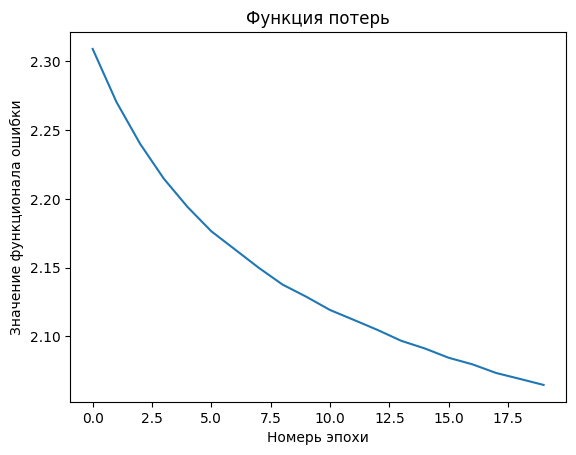

In [69]:
plt.plot(list(losses.keys()), list(losses.values()))
plt.title("Функция потерь")
plt.xlabel("Номерь эпохи")
plt.ylabel("Значение функционала ошибки")
plt.show()

Выполним инференс модели на test части датасета

In [113]:
import torch.nn.functional as F
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
predicted_labels = []
predicted_labels_probas = []
for images, _ in test_loader:
  images = images.to(device)
  # Вызываем no_grad, чтобы не считать на инференсе градиенты
  with torch.no_grad():
    logits = model(images)
  predicted_labels_probas_cur_batch = F.softmax(logits).max(axis=1).values.cpu().detach().numpy()
  predicted_labels_cur_batch = F.softmax(logits).argmax(axis=1).cpu().detach().numpy()
  predicted_labels_probas.extend(predicted_labels_probas_cur_batch)
  predicted_labels.extend(predicted_labels_cur_batch)
predicted_labels = np.array(predicted_labels)
predicted_labels_probas = np.array(predicted_labels_probas)

<ipython-input-113-46161302ae48>:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  predicted_labels_probas_cur_batch = F.softmax(logits).max(axis=1).values.cpu().detach().numpy()
<ipython-input-113-46161302ae48>:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  predicted_labels_cur_batch = F.softmax(logits).argmax(axis=1).cpu().detach().numpy()


Посмотрим на метрики полученной модели

In [114]:
from sklearn.metrics import classification_report

print(classification_report(test_np_labels, predicted_labels, target_names=list(dataset_classes.values())))

              precision    recall  f1-score   support

    airplane       0.30      0.39      0.34      1000
  automobile       0.25      0.29      0.27      1000
        bird       0.21      0.06      0.09      1000
         cat       0.16      0.05      0.08      1000
        deer       0.25      0.15      0.19      1000
         dog       0.28      0.31      0.29      1000
        frog       0.24      0.30      0.27      1000
       horse       0.25      0.17      0.20      1000
        ship       0.32      0.46      0.37      1000
       truck       0.29      0.52      0.37      1000

    accuracy                           0.27     10000
   macro avg       0.25      0.27      0.25     10000
weighted avg       0.25      0.27      0.25     10000



Построим несколько случайных изображений из датасета и предсказания для них модели

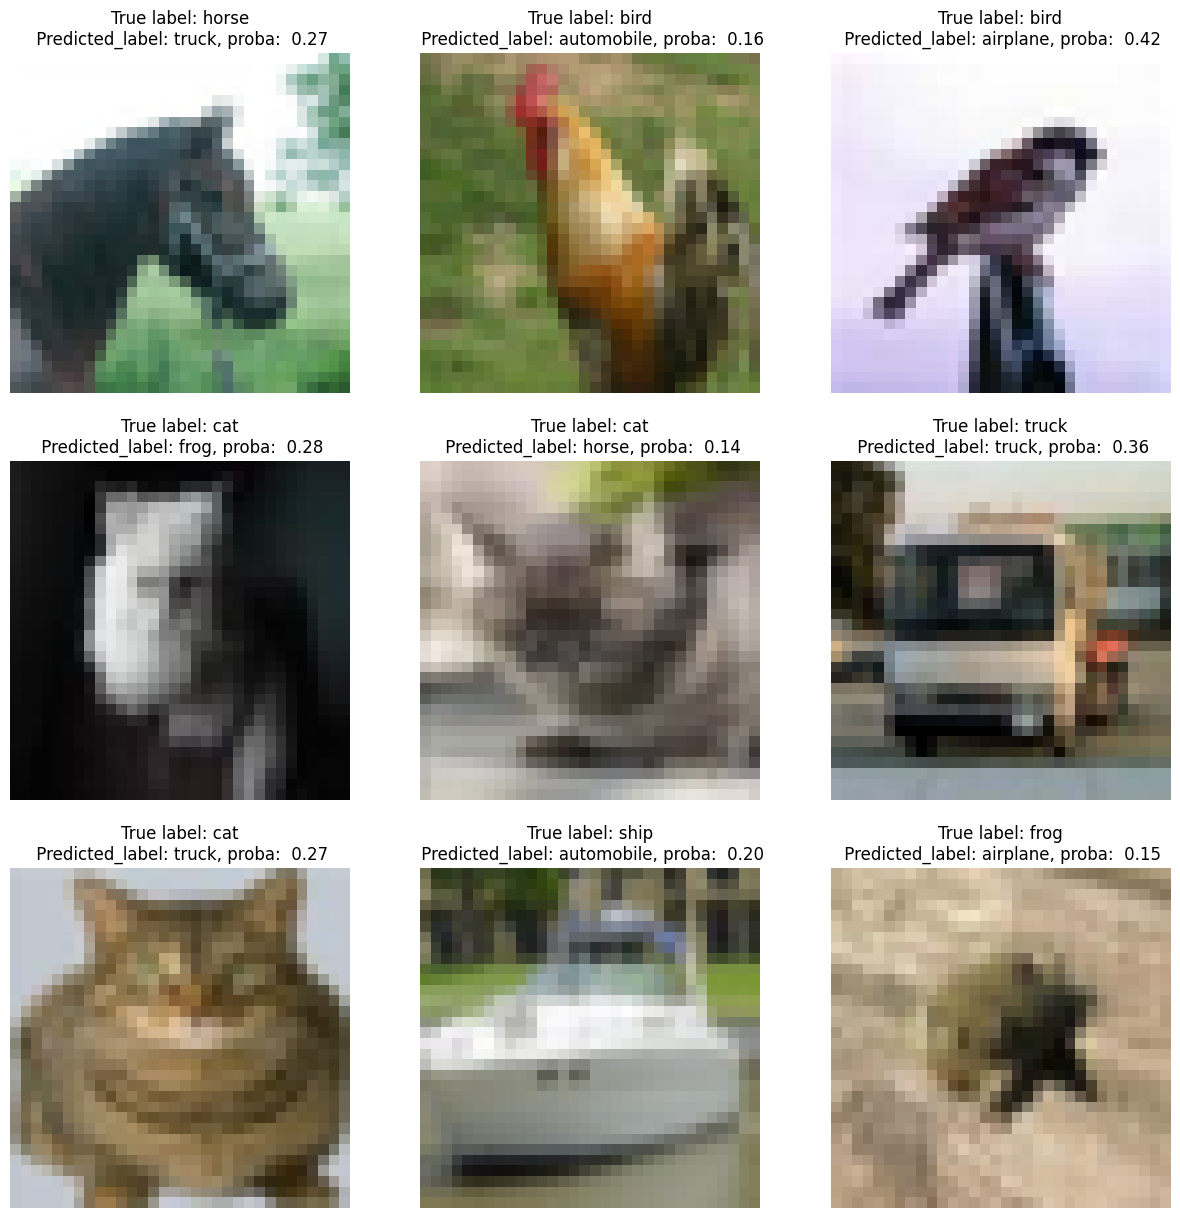

In [119]:
# Преобразования для перевода из PIL изображения в torch tensor.
# Нормализация была удалена для просмотра результата
transform = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)


test_dataset = torchvision.datasets.CIFAR10("/data", train=False, download=True, transform=transform)
test_np_images, test_np_labels = torch_dataset_to_numpy(test_dataset)
random_indices_for_demo = np.random.choice(np.arange(1, test_np_images.shape[0]), size=9, replace=False).reshape(3, 3)

fix, axes = plt.subplots(3, 3, figsize=(15, 15))

for i in range(3):
  for j in range(3):
    image_idx = random_indices_for_demo[i, j]
    image = test_np_images[image_idx].reshape(3, 32, 32).transpose(1, 2, 0)
    axes[i][j].imshow(image)
    proba = predicted_labels_probas[image_idx]
    true_label = dataset_classes[test_np_labels[image_idx]]
    predicted_label = dataset_classes[predicted_labels[image_idx]]
    title = f"True label: {true_label}\n Predicted_label: {predicted_label}, proba: {proba: .2f}"
    axes[i][j].set_title(title)
    axes[i][j].axis("off")
plt.axis("off")
plt.show()

### Сравнение KNN и простой полносвязной сети

KNN показала более хорошее качество, чем предложенная полносвязная сеть. Это связано с несколькими вещами. Во-первых так как сеть полносвязная она не учитывает пространственную структуру изображения в этом могут помочь применение следующих техник (трансформеры, операций свертки), второе сеть обучалась маленькое количество эпох для демонстрации ее работы. Это видно по вероятностам для классов, которые она выдает. Объединение этих двух техник могло бы существенно улучшить качество сети на датасете CIFAR10